In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

import theano_shim as shim
import sinn
from sinn.histories import Spiketrain, Series
import sinn.iotools as io
import sinn.analyze as anlz

import main

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

try:
    # Guard against defining multiple loggers
    logger
except NameError:
    rootlogger = logging.getLogger()
    rootlogger.setLevel(logging.INFO)

    sthandler = logging.StreamHandler()
    sthandler.setLevel(logging.INFO)
    sthandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(sthandler)
    
    filehandler = logging.handlers.RotatingFileHandler(
        'fsgif.log', mode='w', maxBytes=5e5, backupCount=5)
    filehandler.setLevel(sinn.LoggingLevels.MONITOR)
    filehandler.setFormatter(sinn.config.logging_formatter)
    rootlogger.addHandler(filehandler)
    
    logger = logging.getLogger('fsgif')
    logger.setLevel(logging.INFO)

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
[monochrome_palette]: value was greater than 1 and was clipped.


In [2]:
rootlogger.handlers

In [3]:
spiketrain = Spiketrain.from_raw(io.loadraw("spikes_4s_sin-input_spikes_raw.dat"))

In [4]:
anlz.plot(spiketrain)

2017-06-13 11:34:13,371 - sinn.analyze - WARNING - Plotting of <class 'sinn.histories.Spiketrain'> data is not currently supported.


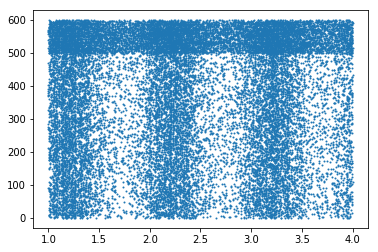

In [15]:
#fig, ax = plt.subplots(figsize=(figwidth, figheight))
    #plt.subplots_adjust(top=1, right=1, bottom=0, left=0)
    
data = spiketrain._data
lineheight = 1
markersize = 1
maxN = None
burnin = 1.0

tarr = spiketrain._tarr[data.row]
idcs = np.where(np.logical_and(tarr > burnin, tarr < burnin+10))[0]
t_slice = slice(data.row[idcs].argmin(), data.row[idcs].argmax())

plt.scatter(spiketrain._tarr[data.row[idcs]], data.col[idcs]*lineheight, 
            s=markersize, linestyle='None')

In [13]:
Atrace = Series(spiketrain, name='A', shape=(1,))
Atrace.set(data.tocsr()[spiketrain.t0idx: spiketrain.t0idx + len(spiketrain)].sum(axis=1).A)

(0, 80)

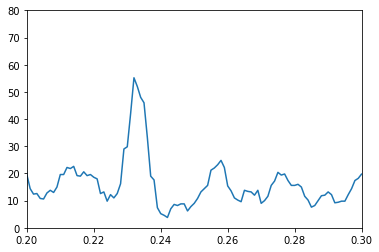

In [14]:
anlz.plot(anlz.smooth(Atrace, 5))

plt.xlim(0.2, )
plt.ylim(0, 80)

In [92]:
activity_train = Series.from_raw(io.loadraw("fsgif_mf_raw.dat"))

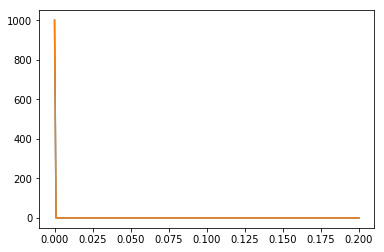

In [93]:
anlz.plot(activity_train)

In [2]:
import main
spikemodel = main.generate_spikes(2,
                                  filename='fsgif_2s_sin-input_hi-res.dat',
                                  recalculate=False)

2017-06-14 15:44:35,236 - root - INFO - Checking for precomputed data...
2017-06-14 15:44:35,242 - root - INFO - No precomputed data found. Generating new data...
2017-06-14 15:47:59,382 - root - INFO - Done.
2017-06-14 15:47:59,383 - sinn - WARNING - Some probabilities were clipped.


In [3]:
shist = spikemodel.s
shist.lock()

mfIhist = anlz.subsample(spikemodel.I_ext, np.rint(main.mf_dt / main.spike_dt).astype('int'))
mfIhist.lock()

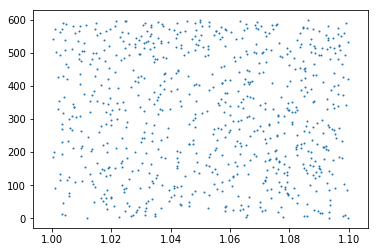

In [4]:
data = spikemodel.s._data
lineheight = 1
markersize = 1
maxN = None
burnin = 1.0
datalen = .1

tarr = spikemodel.s._tarr[data.row]
idcs = np.where(np.logical_and(tarr > burnin, tarr < burnin+datalen))[0]
t_slice = slice(data.row[idcs].argmin(), data.row[idcs].argmax())

plt.scatter(spikemodel.s._tarr[data.row[idcs]], data.col[idcs]*lineheight, 
            s=markersize, linestyle='None')

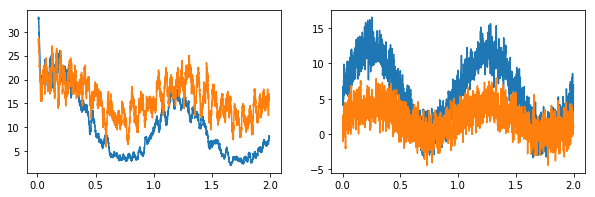

In [5]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
spikeAhist = Series(spikemodel.s, name='A (spikes)', shape=(2,))
summedspikes = np.concatenate(
    [ data.tocsr()[spikemodel.s.t0idx: spikemodel.s.t0idx + len(spikemodel.s), pop_slice].sum(axis=1).A
      for pop_slice in spikemodel.s.pop_slices ],
    axis=1)
spikeAhist.set(summedspikes / (spikemodel.params.N * spikemodel.s.dt))
spikeAhist.lock()
anlz.plot(anlz.smooth(spikeAhist, 100))

plt.subplot(1,2,2)
anlz.plot(anlz.smooth(spikemodel.I_ext, 10))

In [6]:
mfAhist = anlz.subsample(spikeAhist, np.rint(main.mf_dt / main.spike_dt).astype('int'))
mfAhist.lock()

(0.7, 0.8)

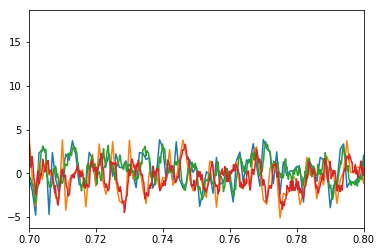

In [7]:
anlz.plot(mfIhist)
anlz.plot(anlz.smooth(spikemodel.I_ext, 10))
plt.xlim((0.7, 0.8))
#plt.legend()

In [8]:
# Generate data from the mean-field model using the same input
mfmodel = main.init_mean_field_model(activity_history = None,
                                     input_history = mfIhist)
mfmodel.A.set()
sinn.flush_log_queue()
mfAhist = mfmodel.A
mfAhist.lock()

2017-06-14 15:48:47,503 - sinn - WARNING - Some probabilities were clipped.


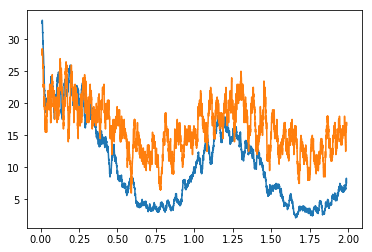

In [ ]:
anlz.plot(anlz.smooth(spikeAhist, 100), label='A (spikes)')

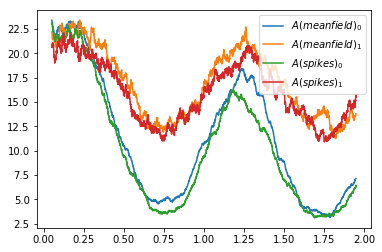

In [ ]:
anlz.plot(anlz.smooth(mfAhist, 100), label='A (mean field)')
anlz.plot(anlz.smooth(spikeAhist, 500), label='A (spikes)')
plt.legend()

In [11]:
import fsgif_model as fsgif
t = 0.0

def pop_mean_spikes(arr):
    return np.stack( [ np.mean(arr[..., popslice], axis=-1)
                       for popslice in shist.pop_slices],
                    axis=-1)

def pop_mean_mf(arr):
    arr = arr[:len(mfmodel.m[t])]
    return (arr * mfmodel.m[t]).sum(axis=0) / mfmodel.m[t].sum(axis=0)

def clip(arr):
    return shim.switch(arr < 1e5, arr, 0)

In [12]:
def diff(hist, mode='centered'):
    """
    Compute the numerical derivative of `hist`
    
    Parameters
    ----------
    hist: History
        Any history, but only really makes sense for Series
    mode: str
        Determines the method used to compute the derivatie. One of
        - 'centered' : Centered differences (default)
           ( hist[l+1] - hist[l-1] ) / (2Δt)
           This consumes two time bins and is O(Δt²).
        - 'forward'  : Forward-difference
           ( hist[l+1] - hist[l] ) / Δt
           This consumes one time bin and is O(Δt)
        - 'backward' : Backward-difference
           ( hist[l] - hist[l-1] ) / Δt
           This consumes one time bin and is O(Δt)
           
    Returns
    -------
    Series
       The length of the series will be slightly reduced by the number of bins
       consumed by the differentiation method.
    """
    
    if mode == 'centered':
        # Remove consumed bins, but only if there's no padding
        if hist.t0idx >= 1:
            t0 = hist.t0
            startidx = hist.t0idx - 1
        else:
            t0 = hist.t0 + hist.dt
            startidx = hist.t0idx
        if len(hist._tarr) > hist.t0idx + len(hist):
            tn = hist.tn
            endidx = hist.t0idx + len(hist) + 1
        else:
            tn = hist.tn - hist.dt
            endidx = hist.t0idx + len(hist)
            
        res = Series(hist, name = "D " + hist.name,
                     t0 = t0, tn = tn)
        res.set( (hist[startidx+2:endidx] - hist[startidx:endidx-2]) / (2*hist.dt) )
        return res
    
    if mode == 'forward':
        # Remove consumed bins, but only if there's no padding
        t0 = hist.t0
        startidx = hist.t0idx
        
        if len(hist._tarr) > hist.t0idx + len(hist):
            tn = hist.tn
            endidx = hist.t0idx + len(hist) + 1
        else:
            tn = hist.tn - hist.dt
            endidx = hist.t0idx + len(hist)
            
        res = Series(hist, name = "D " + hist.name,
                     t0 = t0, tn = tn)
        res.set( (hist[startidx+1:endidx] - hist[startidx:endidx-1]) / (hist.dt) )
        return res
    
    if mode == 'backward':
        # Remove consumed bins, but only if there's no padding
        if hist.t0idx >= 1:
            t0 = hist.t0
            startidx = hist.t0idx - 1
        else:
            hist.t0 + hist.dt
            startidx = hist.t0idx
            
        tn = hist.tn
        endidx = hist.t0idx + len(hist) + 1
            
        res = Series(hist, name = "D " + hist.name,
                     t0 = t0, tn = tn)
        res.set( (hist[startidx+1:endidx] - hist[startidx:endidx-1]) / (hist.dt) )
        return res
    
def mean(hist, pop_slices=None, **kwargs):
    """
    Compute the time-dependent mean, by applying `np.mean` to every time slice
    of `hist`.
    
    Parameters
    ----------
    hist: History
    
    pop_slices: list of slices
        (Optional) If specified, timeslices are subdivided with theses slices
        and the mean is computed for each slice separately.
        TODO: 2d pop_slices ?
        
    **kwargs:
        Forwarded to `np.mean`. Can be use e.g. to limit the mean to one axis.
        
    Returns
    -------
    History, of same length as hist.
    """
    if pop_slices is not None:
        res_data = np.stack(
                       [ np.stack( [ np.mean(hist[i][pop_slice]) 
                                     for pop_slice in pop_slices ] )
                         for i in range(hist.t0idx, hist.t0idx + len(hist)) ] )
    else:
        res_data = np.stack( [ np.mean(hist[i], **kwargs)
                               for i in range(hist.t0idx, hist.t0idx + len(hist)) ] )
    res = Series(hist, name = "<" + hist.name + ">",
                 shape = res_data.shape[1:])
    res.set( res_data )
    return res

In [14]:
mfmodel.u.set()
mfmodel.m.set()
mfmodel.h.set()
mfmodel.x.set()

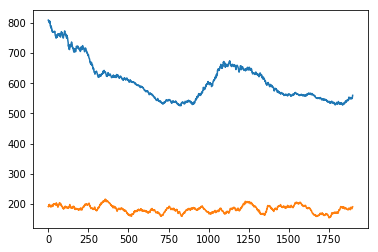

In [16]:
plt.plot(mfmodel.m.get_trace().sum(axis=1)[100:])

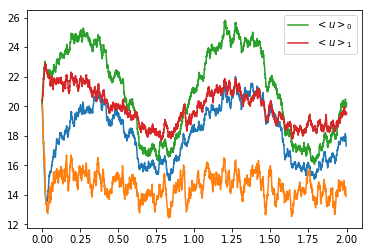

In [15]:
plt.plot( mfmodel.u.get_time_array(),
          ( ( np.sum(mfmodel.u.get_trace([slice(None,2306)]) * mfmodel.m.get_trace(),
                   axis=1)
              + mfmodel.h.get_trace() * mfmodel.x.get_trace() )
            / (mfmodel.m.get_trace().sum(axis=1) + mfmodel.x.get_trace()) ) )
anlz.plot(anlz.analyze.mean(spikemodel.u, spikemodel.s.pop_slices))
#plt.ylim((0,26))
plt.legend()

In [20]:
mfmodel.u[2]

ShimmedShared([[  0.    ,   0.    ],
       [  1.3692,   1.1547],
       [ 20.7233,  20.5263],
       ..., 
       [ 20.7233,  20.5263],
       [ 20.7233,  20.5263],
       [ 20.7233,  20.5263]])

In [103]:
spikemodel.t_hat.shape

(600,)

In [99]:
spikemodel.u_fn(0.0002)

array([ 20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.123,  20.123,  20.123,  20.123,  20.123,  20.123,
        20.123,  20.

In [93]:
anlz.analyze.mean(spikemodel.u, spikemodel.s.pop_slices)[:10]

ShimmedShared([[ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362],
       [ 20.123,  20.362]])

In [90]:
mfmodel.u[0]

ShimmedShared([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       ..., 
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]])

In [81]:
mfmodel.h[t] * mfmodel.x[t]

ShimmedShared([ 602.406572,   99.584431])

In [83]:
mfmodel.h[t]

ShimmedShared([ 1.204813,  0.995844])

In [89]:
self.h_tot[t]

ShimmedShared([ 20.346403,  20.364778])

In [68]:
mfmodel.A[5]

ShimmedShared([ 28.,  20.])

In [62]:
mfmodel.u[1]

ShimmedShared([[ 0.      ,  0.      ],
       [ 1.204813,  0.995844],
       [ 1.204813,  0.995844],
       ..., 
       [ 1.204813,  0.995844],
       [ 1.204813,  0.995844],
       [ 1.204813,  0.995844]])

In [48]:
print("u (spikes)")
print(pop_mean_spikes(spikemodel.u[t]))
print("u (mf)")
print(pop_mean_mf(mfmodel.u[t]))

u (spikes)
[ 20.123  20.362]
u (mf)
[ nan  nan]


In [28]:
print("varθ (spikes)")
print(pop_mean_spikes(clip(spikemodel.varθ[t])))
print("varθ (mf)")
print(pop_mean_mf(clip(mfmodel.varθ[t])))

varθ (spikes)
[ 21.2702  13.35  ]
varθ (mf)
[ 21.1713  14.1631]


In [32]:
np.set_printoptions(precision=6, suppress=True)
print("λ * dt (spikes)")
print(pop_mean_spikes(spikemodel.λ[t] * shist.dt))
print("nbar / N (mf)")
print(pop_mean_mf(mfmodel.nbar[t] / mfmodel.params.N))

λ * dt (spikes)
[ 0.001783  0.004532]
nbar / N (mf)
[ 0.00758   0.005522]


In [143]:
print( "Γ (spikes)" )
print( np.stack([
    np.stack([ np.mean(spikemodel.params.Γ[popslice1, popslice2]) 
               for popslice2 in shist.pop_slices ])
    for popslice1 in shist.pop_slices
]) * spikemodel.params.w )
print("p * w (mf)")
print( mfmodel.params.p * mfmodel.params.w )

Γ (spikes)
[[ 0.017762 -0.117753]
 [ 0.023471 -0.096244]]
p * w (mf)
[[ 0.017758 -0.118568]
 [ 0.02369  -0.096244]]


In [33]:
self = mfmodel
tidx_y = self.y.get_t_idx(t)
red_factor_τm = shim.exp(-self.h_tot.dt/self.params.τ_m)
red_factor_τs = shim.exp(-self.h_tot.dt/self.params.τ_s)
mfarr = ( self.params.τ_m * (self.params.p * self.params.w) * self.params.N
                       * (self.A_Δ[t]
                          + ( ( self.params.τ_s * red_factor_τs * ( self.y[tidx_y] - self.A_Δ[t] )
                                - red_factor_τm * (self.params.τ_s * self.y[tidx_y] - self.params.τ_m * self.A_Δ[t]) )
                              / (self.params.τ_s - self.params.τ_m) ) ) ).sum(axis=-1)

In [35]:
print("RI_syn * (1 - red_factor) (spike)")
print(pop_mean_spikes(spikemodel.RI_syn[t])
      * (1 - np.exp(-shist.dt/spikemodel.params.τ_m)) * 5) # *5 because different dt
print("'equivalent' (mf)")
print(pop_mean_mf(mfarr))

RI_syn * (1 - red_factor) (spike)
[-0.228271 -0.146704]
'equivalent' (mf)
[-0.295896 -0.209352]


In [37]:
print("u_rest * (1 - red_factor) (spikes)")
red_factor = np.exp(-shist.dt/spikemodel.params.τ_m)
print(spikemodel.params.u_rest * (1 - red_factor) * 5)
print("u_rest * (1 - red_factor) (mf)")
red_factor = np.exp(-mfmodel.u.dt/mfmodel.params.τ_m)
print(mfmodel.params.u_rest * (1 - red_factor))

u_rest * (1 - red_factor) (spikes)
[ 1.001136  1.013026]
u_rest * (1 - red_factor) (mf)
[ 0.98141   0.993066]


In [40]:
print("RI_ext * (1 - red_factor) (spike)")
print(spikemodel.params.R * np.mean(spikemodel.I_ext[t:t+5*main.spike_dt])
      * (1 - np.exp(-shist.dt/spikemodel.params.τ_m)) * 5 )
print("RI_ext * (1 - red_factor) (mf)")
print(mfmodel.params.R * mfmodel.I_ext[t] 
      * (1 - np.exp(-mfmodel.A.dt/mfmodel.params.τ_m)) )

RI_ext * (1 - red_factor) (spike)
[ 0.130419  0.130419]
RI_ext * (1 - red_factor) (mf)
[ 0.190564  0.065134]


In [41]:
print("u[t-1] * red_factor (spike)")
tidx_u = spikemodel.u.get_t_idx(t)
red_factor = np.exp(-shist.dt/spikemodel.params.τ_m)
print(pop_mean_spikes(spikemodel.u[tidx_u-1]) * red_factor)
print("u[t-1] * red_factor (mf)")
tidx_u = mfmodel.u.get_t_idx(t)
red_factor = np.exp(-mfmodel.u.dt/mfmodel.params.τ_m)
print(pop_mean_mf(mfmodel.u[tidx_u-1]) * red_factor)

u[t-1] * red_factor (spike)
[ 20.831524  19.422054]
u[t-1] * red_factor (mf)
[ 17.465597  13.411347]


In [36]:
18.9578 + .9814 + .3355 + -.1073

20.1674

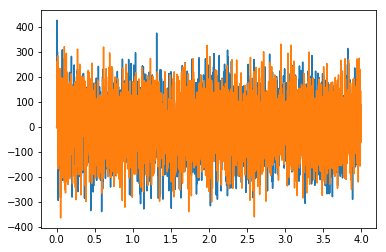

In [34]:
anlz.plot(diff(mean(spikemodel.u, spikemodel.s.pop_slices), 'forward'))
plt.xlim()

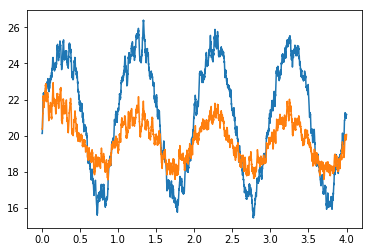

In [35]:
anlz.plot(mean(spikemodel.u, spikemodel.s.pop_slices))

In [63]:
mfu = Series(mfmodel.u, shape=(2,))
mfu.set(np.sum(mfmodel.u.get_trace([slice(None,2306)]) * mfmodel.m.get_trace() 
                 / mfmodel.m.get_trace().sum(axis=1, keepdims=True),
                 axis=1))
spikeu = mean(spikemodel.u, spikemodel.s.pop_slices)

In [79]:
temp = diff(mfu, 'forward') - diff(spikeu, 'forward')
temp.set()

In [109]:
t1 = diff(mfu, 'forward')
t2 = diff(spikeu, 'forward')
t1bar = np.mean(t1[100:], axis=0)
t2bar = np.mean(t2[100:], axis=0)
t3 = (t1 - t1bar)
t4 = (t2 - t2bar)
t3.set()
t4.set()
temp2 = t3 * t4
temp2.set()

In [125]:
np.mean(np.sign(diff(mfu, 'forward')[100:]))

ShimmedShared(0.02666666666666667)

In [124]:
np.mean(np.sign(diff(mfu, 'forward')[100:]) * np.sign(diff(spikeu, 'forward')[100:]))

ShimmedShared(0.46717948717948715)

In [102]:
np.mean(temp[100:], axis=0)

ShimmedShared([ 0.687361,  0.183836])

In [119]:
np.mean(temp2[100:], axis=0) / np.sqrt( np.mean(t3[100:]**2, axis=0) 
                                       * np.mean(t4[100:]**2, axis=0) )

ShimmedShared([ 0.851813,  0.451926])

In [139]:
print( np.mean(abs(diff(mfu, 'forward')[100:]), axis=0) )
print( np.mean(abs(diff(spikeu, 'forward')[100:]), axis=0) )

[  94.35251   152.794143]
[ 85.142725  81.177556]


In [92]:
temp[-10:]

ShimmedShared([[  -7.033778,   14.005914],
       [  22.091037,  150.310298],
       [-127.389354,    7.910544],
       [-177.803499,  -86.500831],
       [  -2.434879, -280.470883],
       [ -26.359484,   57.628451],
       [  44.950745,    6.806638],
       [ 106.223866,  -17.425307],
       [ -23.892469,  159.901442],
       [-112.356428, -680.680063]])

(1, 1.1)

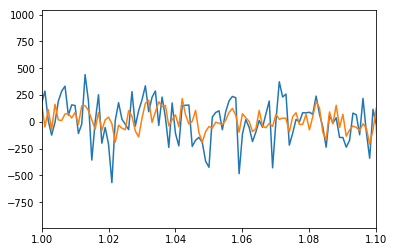

In [87]:
anlz.plot(diff(mfu, 'forward'), component=1)
anlz.plot(diff(spikeu, 'forward'), component=1)
plt.xlim((1, 1.1))

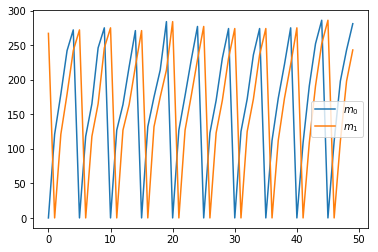

In [18]:
anlz.plot(mfmodel.m[0.2:0.25][:,:6,0], label='m')
plt.legend()

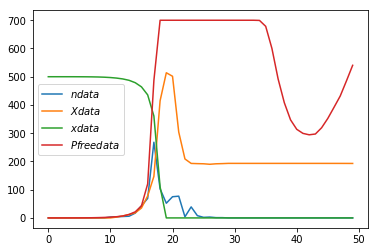

In [9]:
anlz.plot(mfmodel.n[0.0:0.05], component=0)
#anlz.plot(mfmodel.m[0.0:0.05][:,:6,0], label='m')
anlz.plot(mfmodel.X[0.0:0.05], component=0)
anlz.plot(mfmodel.x[0.0:0.05], component=0)
anlz.plot(mfmodel.Pfree[0.0:0.05]*700, component=0, label='Pfree')
#plt.xlim((0, 0.05))
plt.legend()

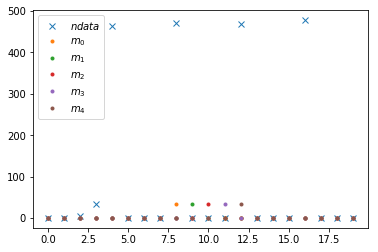

In [19]:
anlz.plot(mfmodel.n[0.02:0.04], component=0, marker='x', linestyle='None')
anlz.plot(mfmodel.m[0.02:0.04][:,4:,0], marker='.', linestyle='None', label='m')
plt.legend()

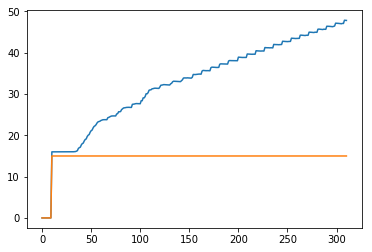

In [5]:
anlz.plot(mfmodel.varθ[:][:,4,:])
#plt.ylim((0,10))K
#plt.legend()

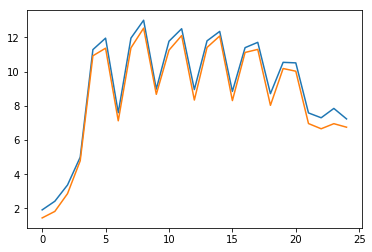

In [6]:
anlz.plot(mfmodel.u[:][15:40:,1,:])

In [27]:
mfmodel.params.u_rest

ShimmedShared([ 20.,  20.])

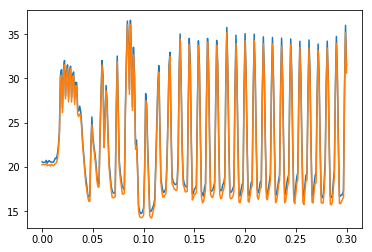

In [7]:
anlz.plot(mfmodel.h_tot)

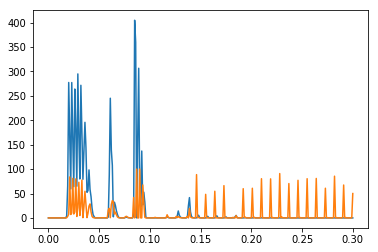

In [8]:
anlz.plot(mfmodel.W)

In [5]:
print(np.concatenate((mfmodel.x[0.012:0.025][:,0:1],
                      mfmodel.X[0.012:0.025][:,0:1],
                      mfmodel.m[0.012:0.025][:,:6,0]),
     axis=1))

[[ 492.14     7.       4.       3.       0.       0.       0.       0.   ]
 [ 487.312   12.       5.       4.       3.       0.       0.       0.   ]
 [ 478.806   18.       6.       5.       4.       3.       0.       0.   ]
 [ 464.049   35.      17.       6.       5.       4.       3.       0.   ]
 [ 435.692   77.999   43.      17.       6.       5.       4.       3.   ]
 [ 360.737  146.996   69.      43.      17.       6.       4.999    3.999]
 [ 109.945  414.972  268.      69.      43.      17.       5.998    4.995]
 [   0.     514.076  103.     268.      69.      43.      16.611    5.613]
 [   0.     503.68    52.     103.     268.      69.      11.627    0.053]
 [   0.     510.884   87.      52.     103.     268.       0.884    0.   ]
 [   0.     513.403  263.      87.      52.     103.       8.403    0.   ]
 [   0.     512.016   69.     263.      87.      52.      41.016    0.   ]
 [   0.     513.448   94.      69.     263.      87.       0.448    0.   ]]


In [26]:
mfmodel.n[0.012:0.025][:,0]

ShimmedShared([   5.,    6.,   17.,   43.,   69.,  268.,  103.,   52.,   75.,
         77.,    4.,   39.,    8.])

In [44]:
mfmodel.X[0.021]

ShimmedShared([ 304.152,   96.936])

In [45]:
mfmodel.W[0.020]

ShimmedShared([ 78.616,   2.478])

In [52]:
((mfmodel.P_λ[0.020])*mfmodel.m[0.020]*mfmodel.ref_mask[:-1]).sum(axis=0)

ShimmedShared([ 78.616,   2.478])

In [6]:
mfmodel.P_λ[0.020][:10]

ShimmedShared([[ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.   ,  0.   ],
       [ 0.987,  0.985],
       [ 1.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 1.   ,  1.   ],
       [ 1.   ,  1.   ]])

In [17]:
mfmodel.θ_dis[:10]

ShimmedShared([[   inf,    inf],
       [   inf,    inf],
       [   inf,    inf],
       [ 1.   ,  0.   ],
       [ 0.999,  0.   ],
       [ 0.998,  0.   ],
       [ 0.997,  0.   ],
       [ 0.996,  0.   ],
       [ 0.995,  0.   ],
       [ 0.994,  0.   ]])

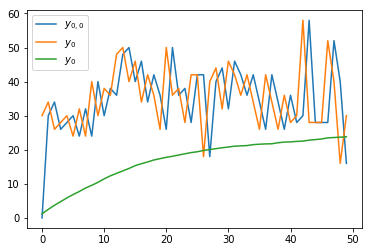

In [43]:
anlz.plot(mfmodel.A_Δ[0.0:0.05], component=[(0, 0)])
anlz.plot(mfmodel.A[0.0:0.05], component=[(0,)])
anlz.plot(mfmodel.h[0.0:0.05], component=0)
plt.legend()

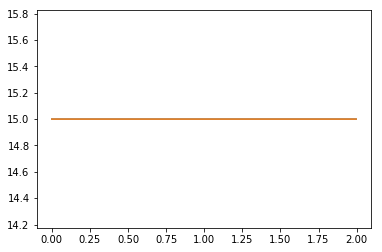

In [44]:
anlz.plot(mfmodel.varθfree)

In [46]:
mfmodel.varθ.t0idx

2307

In [4]:
mfmodel.θtilde_dis[:]

ShimmedShared([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.00156661,  0.        ],
       [ 0.00156782,  0.        ],
       [ 0.00156903,  0.        ],
       [ 0.00157024,  0.        ],
       [ 0.00157145,  0.        ],
       [ 0.00157266,  0.        ],
       [ 0.004     ,  0.02      ],
       [ 0.004     ,  0.02      ],
       [ 0.004     ,  0.02      ],
       [ 0.004     ,  0.02      ],
       [ 0.004     ,  0.02      ]])

In [51]:
mfmodel.θ2.eval(0.01)

array([ 0.99401796,  0.        ])

In [48]:
mfmodel.params.t_ref

ShimmedShared([ 0.004,  0.004])

In [17]:
shim.concatenate([(y[i] * shim.ones((N[i],), dtype='float64')).shape.eval({x: xval})  for i in range(3)])#.shape.eval({x: xval}) 

array([4, 2, 3])